In [1]:
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision

from models import *

---

In [2]:
batch_size=100
transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
trainset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transform_test)
testset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=16)
dataloaders = {}

dataloaders['train'] = train_loader
dataloaders['test'] = test_loader

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Represent(nn.Module):
    def __init__(self, base_model):
        super(Represent, self).__init__()
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.fc = base_model.fc
        self.avgpool = base_model.avgpool
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        return out

---

In [4]:
def get_statistics(dataloaders, device, representer, model, mode = 'train'):
    label_list = np.empty((0,))
    logit_sum_list = np.empty((0,))


    for idx, data in enumerate(dataloaders[mode]):
        image = data[0].to(device)
        label = data[1].long().to(device)

        output = representer(image)
        pred = model(image)
        
        logit_sum = torch.sum(pred, dim=1)
        pred = F.softmax(pred, dim=1)
        score, prediction = torch.max(pred, dim=1)
        
        label_list = np.concatenate((label_list, label.cpu()))
        logit_sum_list = np.concatenate((logit_sum_list, logit_sum.detach().cpu()))

        if idx ==0:
            out_list  = output.detach().cpu()
            pred_list = (prediction == label).detach().cpu()
            score_list = score.detach().cpu()
        else:
            out_list  = np.concatenate((out_list, output.detach().cpu()), axis=0)
            pred_list = np.concatenate((pred_list, (prediction == label).detach().cpu()), axis=0)
            score_list = np.concatenate((score_list, score.detach().cpu()), axis=0)
            
    return label_list, out_list, pred_list, score_list, logit_sum_list

In [5]:
def get_singular_value_vector(label_list, out_list):
    
    singular_dict = {}
    v_ortho_dict = {}
    
    for index in np.unique(label_list):
        u, s, v = np.linalg.svd(out_list[label_list==index])
        singular_dict[index] = s[0] / s[1]
        v_ortho_dict[index] = torch.from_numpy(v[:2])

    return singular_dict, v_ortho_dict

In [6]:
def get_plane(v_ortho_dict, model_represents, label, device):
    # class 0,1,2
    model_represents = torch.from_numpy(model_represents).to(device)
    out = None
    sing_lbl = torch.zeros(model_represents.shape[0]) > 0.
    
    for i, data in enumerate(model_represents):
        if label[i] == 0 or label[i] == 3 or label[i] == 6:
            data = data.to(device)
            tmp = torch.zeros(3)
            for j in range(3):
                tmp[j] = torch.dot(v_ortho_dict[j*3].to(device), data)
            if out == None:
                out = tmp.unsqueeze(0)
            else:
                out = torch.cat((out, tmp.unsqueeze(0)), dim=0)
            sing_lbl[i] = True
    return out.detach().cpu().numpy(), sing_lbl.detach().cpu().numpy()

In [7]:
def make_orthonormal_basis(out):
    a = (out[0]-out[1]) / np.linalg.norm(out[0]-out[1])
    b= (out[1] - out[2]) - np.dot(out[1] - out[2], a) * a
    b = b / np.linalg.norm(b)
    
    return a, b

In [8]:
def projection(out, a, b):
    x = []
    y = []
    for idx, data in enumerate(out):
        x.append(np.dot(data, a))
        y.append(np.dot(data, b))

    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [9]:
def compute_intra_cluster_divergence(cluster1):
    cl1_mean = np.mean(cluster1, axis=0)
    intra_cluster_divergence = 0

    for i in range(cluster1.shape[0]):
        intra_cluster_divergence += np.linalg.norm(cluster1[i] - cl1_mean) ** 2
                
    return intra_cluster_divergence

In [10]:
def verify_cluster(x, y, label_list, sing_lbl):
    cluster1 = np.concatenate((np.expand_dims(np.array(x[label_list[sing_lbl]==0]), 0), np.expand_dims(np.array(y[label_list[sing_lbl]==0]), 0)),axis=0).transpose()
    cluster2 = np.concatenate((np.expand_dims(np.array(x[label_list[sing_lbl]==3]), 0), np.expand_dims(np.array(y[label_list[sing_lbl]==3]), 0)),axis=0).transpose()
    cluster3 = np.concatenate((np.expand_dims(np.array(x[label_list[sing_lbl]==6]), 0), np.expand_dims(np.array(y[label_list[sing_lbl]==6]), 0)),axis=0).transpose()
    
    cl1_mean = np.mean(cluster1, axis=0)
    cl2_mean = np.mean(cluster2, axis=0)
    cl3_mean = np.mean(cluster3, axis=0)

    all_mean = (cl1_mean + cl2_mean + cl3_mean) / 3
    
    inter_cluster_divergence = (np.linalg.norm(cl1_mean - all_mean)**2 + np.linalg.norm(cl2_mean - all_mean)**2 + np.linalg.norm(cl3_mean - all_mean)**2)/3
    intra_cluster_divergence = compute_intra_cluster_divergence(cluster1) + compute_intra_cluster_divergence(cluster2) + compute_intra_cluster_divergence(cluster3)
    
    return inter_cluster_divergence, intra_cluster_divergence
    

---

# SNR

In [12]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_sin_srip_0.01_0.01_0.01_0.01_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [13]:
teacher = teacher.to(device)
representer = Represent(teacher)

In [14]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='train')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

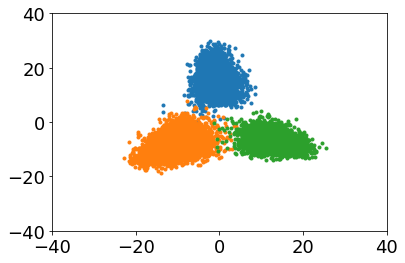

In [17]:
## snr
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})
plt.savefig('snr_visual_train.pdf')

In [18]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='test')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
# a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

(184.60297218622478, 99945.31136108417)


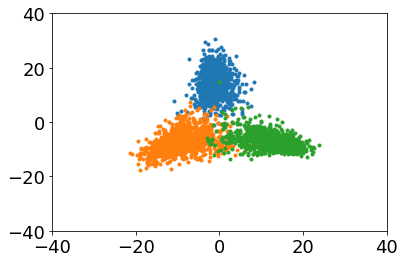

In [19]:
## VANILLA
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})
plt.savefig('snr_visual_test.pdf')
print(verify_cluster(x,y,label_list, sing_lbl))

In [20]:
99945.31136108417 / 3000

33.31510378702806

In [21]:
184.60297218622478 / 33.31510378702806/2 * 2997

8303.36761336366

# Vanilla

In [17]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [18]:
teacher = teacher.to(device)
representer = Represent(teacher)

In [19]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='train')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

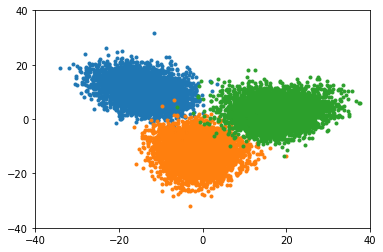

In [20]:
## VANILLA
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})
plt.savefig('vanilla_visual_train.pdf')

In [21]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='test')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
# a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

(223.52828111200142, 177637.01646143553)


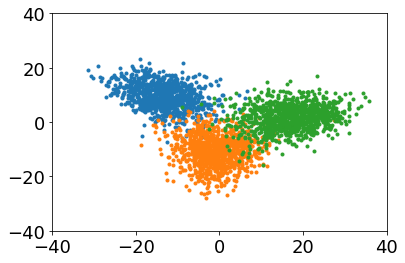

In [22]:
## VANILLA
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})
plt.savefig('vanilla_visual_test.pdf')
print(verify_cluster(x,y,label_list, sing_lbl))

In [23]:
196095.67151793756 / 1000 / 3 

65.36522383931252

In [51]:
223.52828111200142 / 65.36522383931252 /2 * 2997

5124.393516493725

---

# norm

In [26]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt'

# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [27]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='train')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

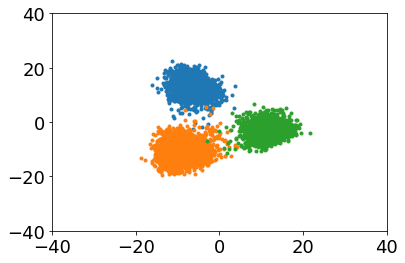

In [28]:
## orn
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})
plt.savefig('norm_visual_train.pdf')
# print(verify_cluster(x,y,label_list, sing_lbl))

In [29]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='test')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
# a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

(159.5977688696812, 59464.16261313985)


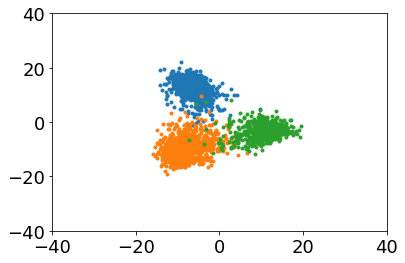

In [30]:
## orn
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})

plt.savefig('norm_visual_test.pdf')
print(verify_cluster(x,y,label_list, sing_lbl))

In [31]:
59464.16261313985 / 3000

19.821387537713285

In [52]:
159.5977688696812 / 19.821387537713285 /2 * 2997

12065.616304417805

---

# SRIP

In [33]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/kaiming_both_srip_0.1_0.1_0.1_0.1_seed1.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [34]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='train')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

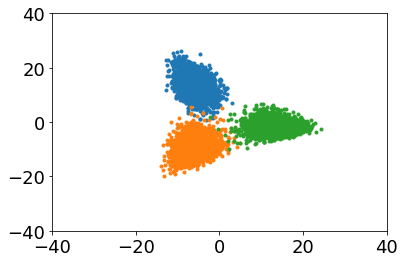

In [35]:
## ortho
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.rcParams.update({'font.size': 18})

plt.savefig('srip_visual_train.pdf')
# print(verify_cluster(x,y,label_list, sing_lbl))

In [36]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='test')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
# a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

(151.23108302328515, 63581.0422315414)


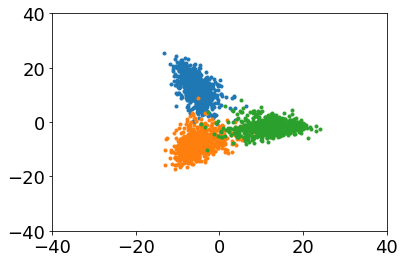

In [37]:
## ortho
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.savefig('srip_visual_test.pdf')
print(verify_cluster(x,y,label_list, sing_lbl))

In [38]:
63581.0422315414 / 3000

21.193680743847136

In [53]:
151.23108302328515 / 21.193680743847136/2 * 2997


10692.799455148166

---

# srip +

In [47]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [41]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='train')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

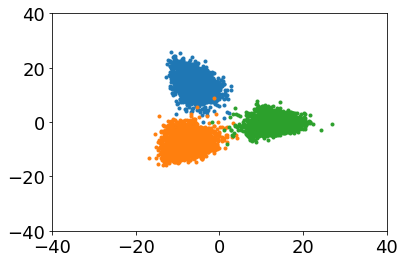

In [42]:
## norm
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.savefig('srip_p_visual_train.pdf')
# print(verify_cluster(x,y,label_list, sing_lbl))

In [43]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode='test')
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)
v_ortho_dict = teacher.fc.weight
out, sing_lbl = get_plane(v_ortho_dict,out_list, label_list, device)
# a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

(145.01338327096437, 60335.325587749496)


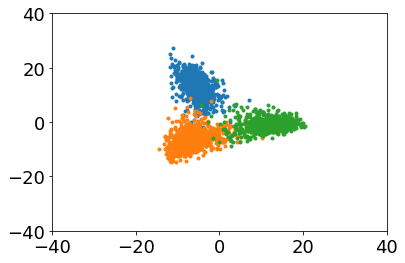

In [44]:
## norm
plt.plot(x[label_list[sing_lbl]==0],y[label_list[sing_lbl]==0],'.')
plt.plot(x[label_list[sing_lbl]==3],y[label_list[sing_lbl]==3],'.')
plt.plot(x[label_list[sing_lbl]==6],y[label_list[sing_lbl]==6],'.')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.savefig('srip_p_visual_test.pdf')
print(verify_cluster(x,y,label_list, sing_lbl))

In [45]:
60335.325587749496 / 3000 

20.111775195916497

In [54]:
145.01338327096437 / 20.111775195916497/2 * 2997


10804.742630360213

In [240]:
vanilla_norm = np.linalg.norm(out_list, axis=1)

In [225]:
orn_norm = np.linalg.norm(out_list, axis=1)

(array([2.200e+01, 3.350e+02, 2.222e+03, 3.797e+03, 2.482e+03, 8.630e+02,
        2.230e+02, 4.500e+01, 9.000e+00, 2.000e+00]),
 array([ 9.162148, 10.817671, 12.473192, 14.128715, 15.784237, 17.439758,
        19.095282, 20.750803, 22.406324, 24.061848, 25.71737 ],
       dtype=float32),
 <a list of 10 Patch objects>)

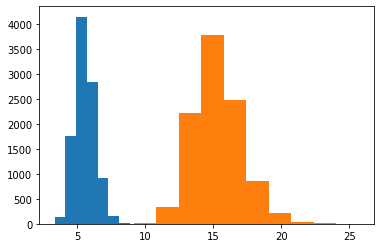

In [241]:
plt.hist(vanilla_norm)
plt.hist(orn_norm)